In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import copy
import sys
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import train_test_split


In [2]:
fileroot='2024_03_08_TRF_Maleen/'
filename='2024_03_08_TRF_Maleen_01'

datapath='/home/maleen/research_data/Transformers/datasets/training/'

# Load the DataFrame from the pickle file
df1 = pd.read_pickle(datapath + filename + '.pkl')

arrays = [np.array(item) for item in df1['Skeleton_3D']]
timestamps = [np.array(item) for item in df1['Skeleton_Timestamp']]

# Convert datetime to seconds from start
timestamps = (timestamps - timestamps[0])

# Stack these arrays along a new axis to create a 3D NumPy array
# Each "slice" of this 3D array represents one frame of keypoints
skeleton_3d_frames = np.stack(arrays, axis=0)

In [3]:
# Assume skeleton_3d_frames is already defined
# skeleton_3d_frames shape is (1020, 18, 3)

# Indices of the joints to be removed
joints_to_remove = [9, 10, 12, 13]

# Create a mask to keep the joints that are not to be removed
mask = np.ones(skeleton_3d_frames.shape[1], dtype=bool)
mask[joints_to_remove] = False

# Update skeleton_3d_frames to remove the specified joints
skeleton_3d_frames_updated = skeleton_3d_frames[:, mask, :]

# Original connections
original_connections = [
    (16, 14), (14, 0),               # Right Head
    (17, 15), (15, 0),               # Left Head
    (0, 1),                          # Neck
    (1, 2), (2, 3), (3, 4),          # Right arm
    (1, 5), (5, 6), (6, 7),          # Left arm
    (1, 8), (8, 9), (9, 10),         # Right leg
    (1, 11), (11, 12), (12, 13),     # Left leg
    (8, 11)                          # Between hips
]

# Mapping of old joint indices to new indices
index_mapping = {}
new_index = 0
for old_index in range(skeleton_3d_frames.shape[1]):
    if old_index not in joints_to_remove:
        index_mapping[old_index] = new_index
        new_index += 1

# Update the connections to reflect the new indices
new_connections = []
for connection in original_connections:
    if connection[0] in index_mapping and connection[1] in index_mapping:
        new_connections.append((index_mapping[connection[0]], index_mapping[connection[1]]))

# Print the updated connections
print("Updated skeleton_3d_frames shape:", skeleton_3d_frames_updated.shape)
print("Updated connections:", new_connections)


Updated skeleton_3d_frames shape: (1020, 14, 3)
Updated connections: [(12, 10), (10, 0), (13, 11), (11, 0), (0, 1), (1, 2), (2, 3), (3, 4), (1, 5), (5, 6), (6, 7), (1, 8), (1, 9), (8, 9)]


In [4]:
# Check if there are any NaN values in skeleton_3d_frames_updated
nan_indices = np.isnan(skeleton_3d_frames_updated)

# Find the indices of frames and joints that have NaN values
frames_with_nans, joints_with_nans, _ = np.where(nan_indices)

# Create a set of unique joints that have NaN values
unique_joints_with_nans = set(joints_with_nans)

print("Frames with NaN values:", np.unique(frames_with_nans))
print("Joints with NaN values:", unique_joints_with_nans)

# Find the indices of frames that have NaN values
frames_with_nans = np.unique(np.where(nan_indices)[0])

# Remove the frames with NaN values
skeleton_3d_frames_cleaned = np.delete(skeleton_3d_frames_updated, frames_with_nans, axis=0)
timestamps_cleaned=np.delete(timestamps, frames_with_nans, axis=0)

print("Original shape:", skeleton_3d_frames_updated.shape)
print("New shape after removing frames with NaNs:", skeleton_3d_frames_cleaned.shape)

Frames with NaN values: [   0    1   49   89   90   91   92   93   94   95   96   97   98   99
  100  143  144  145  208  231  232  233  234  239  289  296  325  326
  327  328  329  330  331  332  333  334  337  338  345  346  347  348
  349  350  351  352  353  354  355  356  357  358  359  360  361  362
  363  364  365  366  367  368  369  370  371  372  373  374  375  376
  377  378  379  380  381  382  383  384  385  386  387  388  389  390
  391  392  393  395  422  423  424  425  426  549  550  551  552  553
  554  555  556  557  558  559  560  561  562  563  564  565  566  567
  568  569  570  571  572  573  578  582  669  670  671  672  673  674
  675  676  677  678  679  680  681  685  686  687  688  690  694  695
  696  697  738  739  740  741  742  743  744  745  746  747  748  749
  750  751  752  753  754  755  860  861  862  863  864  865  866  867
  868  872  938 1018 1019]
Joints with NaN values: {2, 4, 6, 7, 13}
Original shape: (1020, 14, 3)
New shape after removing f

In [5]:
# Calculate the differences in position and time
position_diff = np.diff(skeleton_3d_frames_cleaned, axis=0)
time_diff = np.diff(timestamps_cleaned)

# Ensure that time_diff is of shape (n,1,1) so that it broadcasts correctly when dividing
time_diff = time_diff[:, np.newaxis, np.newaxis]


# Now we calculate velocity, handling missing data according to the mask
# Where the mask is False, we will get np.nan
skel_vel = position_diff / time_diff

# Calculate the differences in velocity
velocity_diff = np.diff(skel_vel, axis=0)

# Now we calculate acceleration, handling missing data according to the mask
# Where the mask is False, we will get np.nan
skel_acc = velocity_diff / time_diff[:-1, :, :]  # Use time_diff with one less time dimension

skel_pos= skeleton_3d_frames_cleaned[2:]
skel_vel = skel_vel[1:]

In [6]:
# Now, slice skeleton_3d_frames and skel_vel to match the dimensions of skell_acc
print(skel_pos.shape)
print(skel_vel.shape)
print(skel_acc.shape)

(845, 14, 3)
(845, 14, 3)
(845, 14, 3)


In [7]:
# Initialize arrays to hold the normalized data, medians, and IQRs
norm_pos = np.empty_like(skel_pos)
medians_per_joint_axis_skel_pos = np.empty((skel_pos.shape[1], skel_pos.shape[2]))
iqrs_per_joint_axis_skel_pos = np.empty((skel_pos.shape[1], skel_pos.shape[2]))

norm_vel= np.empty_like(skel_vel)
medians_per_joint_axis_vel = np.empty((skel_vel.shape[1], skel_vel.shape[2]))
iqrs_per_joint_axis_vel = np.empty((skel_vel.shape[1], skel_vel.shape[2]))

norm_acc = np.empty_like(skel_acc)
medians_per_joint_axis_acc = np.empty((skel_acc.shape[1], skel_acc.shape[2]))
iqrs_per_joint_axis_acc = np.empty((skel_acc.shape[1], skel_acc.shape[2]))

def robust_normalize_data_with_clipping(data, medians_per_joint_axis, iqrs_per_joint_axis, normalized_data, clipping_percentiles=(1, 99)):
    for joint in range(data.shape[1]):  # For each joint
        for axis in range(data.shape[2]):  # For each axis (x, y, z)
            joint_axis_data = data[:, joint, axis]

            # Determine clipping thresholds based on percentiles
            lower_threshold, upper_threshold = np.percentile(joint_axis_data, clipping_percentiles)

            # Clip the data based on thresholds
            clipped_values = np.clip(joint_axis_data, lower_threshold, upper_threshold)

            # Calculate median and IQR for clipped data
            median = np.median(clipped_values)
            q75, q25 = np.percentile(clipped_values, [75, 25])
            iqr = q75 - q25

            # Store the calculated medians and IQRs
            medians_per_joint_axis[joint, axis] = median
            iqrs_per_joint_axis[joint, axis] = iqr

            # Normalize the clipped data, avoiding division by zero
            if iqr > 0:
                normalized_values = (clipped_values - median) / iqr
            else:
                normalized_values = clipped_values  # Keep original values if IQR is 0

            # Store the normalized values
            normalized_data[:, joint, axis] = normalized_values

    return normalized_data, medians_per_joint_axis, iqrs_per_joint_axis
# Example usage with your data
# Note: masks, skel_pos, skel_vel, skel_acc should be defined in your context

norm_pos, medians_pos, iqrs_pos = robust_normalize_data_with_clipping(skel_pos, medians_per_joint_axis_skel_pos, iqrs_per_joint_axis_skel_pos, norm_pos)
norm_vel, medians_vel, iqrs_vel = robust_normalize_data_with_clipping(skel_vel, medians_per_joint_axis_vel, iqrs_per_joint_axis_vel, norm_vel)
norm_acc, medians_acc, iqrs_acc = robust_normalize_data_with_clipping(skel_acc, medians_per_joint_axis_acc, iqrs_per_joint_axis_acc, norm_acc)


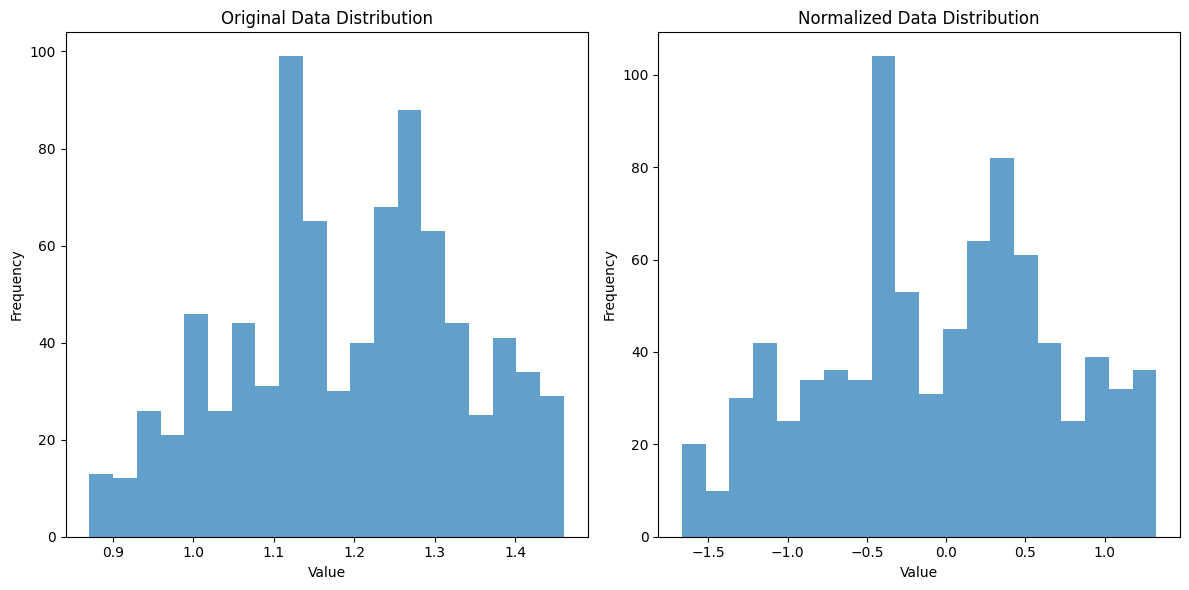

Median of normalized data: 0.0
Data points within [-1, 1] (IQR): 845 out of 845
Original Data points within [-1, 1] (IQR): 98 out of 845


In [8]:
data=skel_pos
norm_data=norm_pos
# Plot the original and normalized data for a specific joint and axis
joint, axis = 0, 0  # Change as needed
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(data[:, joint, axis], bins=20, alpha=0.7, label='Original')
plt.title("Original Data Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(norm_data[:, joint, axis], bins=20, alpha=0.7, label='Normalized')
plt.title("Normalized Data Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Check the median and range of the normalized data
normalized_median = np.nanmedian(norm_data[:, joint, axis])
print("Median of normalized data:", normalized_median)

within_iqr = ((norm_data[:, joint, axis] > -2) & (norm_data[:, joint, axis] < 2)).sum()
print(f"Data points within [-1, 1] (IQR): {within_iqr} out of {norm_data.shape[0]}")

within_iqr2 = ((data[:, joint, axis] > -1) & (data[:, joint, axis] < 1)).sum()
print(f"Original Data points within [-1, 1] (IQR): {within_iqr2} out of {norm_data.shape[0]}")

In [9]:
class SkeletalInputEmbedding(nn.Module):
    def __init__(self, input_dim, embed_dim=128, device='cuda'):
        super(SkeletalInputEmbedding, self).__init__()
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.device = device

        # Linear layer to project input_dim to embed_dim
        self.input_embed = nn.Linear(input_dim, embed_dim)

    def forward(self, joint_positions):
        # joint_positions shape: (batch_size, seq_len, num_joints, dof)
        batch_size, seq_len, num_joints, dof = joint_positions.size()
        input_dim = num_joints * dof  # Total input dimension

        # Reshape to (batch_size * seq_len, num_joints * dof)
        joint_positions = joint_positions.view(batch_size * seq_len, input_dim)

        # Apply the linear layer to project to embed_dim
        embeddings = self.input_embed(joint_positions)

        # Reshape back to (batch_size, seq_len, embed_dim)
        embeddings = embeddings.view(batch_size, seq_len, self.embed_dim)

        # Calculate positional encoding
        positional_encoding = self.get_sinusoidal_encoding(seq_len, self.embed_dim).to(self.device)
        positional_encoding = positional_encoding.unsqueeze(0).expand(batch_size, seq_len, self.embed_dim)

        # Add positional encoding to the embeddings
        embeddings += positional_encoding

        return embeddings

    def get_sinusoidal_encoding(self, total_len, embed_dim):
        position = torch.arange(0, total_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(np.log(10000.0) / embed_dim))
        
        pe = torch.zeros(total_len, embed_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        return pe

In [10]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers, dropout_rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        
        # Transformer Encoder Layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.embed_dim,
            nhead=self.num_heads,
            dropout=self.dropout_rate,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=self.num_layers)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        """
        src: Tensor of shape (batch_size, seq_len, embed_dim)
        src_mask: None or Tensor for masking in multi-head attention (not used in this example)
        src_key_padding_mask: Tensor of shape (batch_size, seq_len) indicating which elements are padded
        """
        # Applying Transformer Encoder
        output = self.transformer_encoder(src, mask=src_mask, src_key_padding_mask=src_key_padding_mask)
        
        return output

In [11]:
class TransformerDecoder(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers, num_joints, dropout_rate=0.1):
        super(TransformerDecoder, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.num_joints = num_joints

        # Transformer Decoder Layer
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=self.embed_dim,  # Keeping d_model consistent with embed_dim
            nhead=self.num_heads,
            dropout=self.dropout_rate,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=self.num_layers)

        # Output layer to convert decoder output to joint position dimension
        self.output_layer = nn.Linear(self.embed_dim, self.num_joints * 3)  # Assuming output per joint is a 3D position

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        """
        tgt: Tensor of shape (batch_size, output_seq_len, embed_dim), initially could be start token or zero vectors
        memory: Tensor of shape (batch_size, input_seq_len, embed_dim), output from the Transformer encoder
        tgt_mask: Mask to ensure the decoder's predictions are based only on past positions
        memory_mask: Optional, to mask encoder outputs if necessary
        tgt_key_padding_mask: Tensor of shape (batch_size, output_seq_len) for masking target sequences
        memory_key_padding_mask: Tensor of shape (batch_size, input_seq_len) for masking memory sequences
        """

        # Transformer Decoder
        output = self.transformer_decoder(
            tgt, memory, tgt_mask=tgt_mask, memory_mask=memory_mask,
            tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask
        )

        # Project to joint position dimensions
        output = self.output_layer(output)

        # Reshape to (batch_size, seq_len, num_joints, 3)
        output = output.view(output.size(0), output.size(1), self.num_joints, 3)

        return output

In [12]:
def generate_sequences(norm_pos, norm_vel, norm_acc, input_length=60, predict_length=60):
    num_frames = norm_pos.shape[0]
    num_joints = norm_pos.shape[1]

    # Calculate the total number of sequences we can create
    num_sequences = num_frames - input_length - predict_length + 1

    # Initialize arrays to store the input and target sequences
    X_pos = np.zeros((num_sequences, input_length, num_joints, 3))
    X_vel = np.zeros((num_sequences, input_length, num_joints, 3))
    X_acc = np.zeros((num_sequences, input_length, num_joints, 3))
    Y_pos = np.zeros((num_sequences, predict_length, num_joints, 3))
    Y_vel = np.zeros((num_sequences, predict_length, num_joints, 3))
    Y_acc = np.zeros((num_sequences, predict_length, num_joints, 3))
    # X_mask = np.zeros((num_sequences, input_length, num_joints))
    # Y_mask = np.zeros((num_sequences, predict_length, num_joints))

    # Create sequences
    for i in range(num_sequences):
        X_pos[i] = norm_pos[i:i + input_length]
        X_vel[i] = norm_vel[i:i + input_length]
        X_acc[i] = norm_acc[i:i + input_length]
        Y_pos[i] = norm_pos[i + input_length:i + input_length + predict_length]
        Y_vel[i] = norm_vel[i + input_length:i + input_length + predict_length]
        Y_acc[i] = norm_acc[i + input_length:i + input_length + predict_length]
        # X_mask[i] = mask[i:i + input_length]
        # Y_mask[i] = mask[i + input_length:i + input_length + predict_length]

    return X_pos, X_vel, X_acc, Y_pos, Y_vel, Y_acc


def create_shifted_mask(seq_length, num_joints):
    # seq_length is the number of time steps
    # num_joints is the number of joints per time step
    total_length = seq_length * num_joints
    mask = torch.ones((total_length, total_length), dtype=torch.float32) * float('-inf')  # Start with everything masked
    for i in range(seq_length):
        for j in range(i + 1):  # Allow visibility up to and including the current time step
            start_row = i * num_joints
            end_row = start_row + num_joints
            start_col = j * num_joints
            end_col = start_col + num_joints
            mask[start_row:end_row, start_col:end_col] = 0.0  # Unmask the allowed region

    return mask

class MaskedMSELoss(nn.Module):
    def __init__(self):
        super(MaskedMSELoss, self).__init__()

    def forward(self, output, target):
        # Compute the squared differences
        squared_diff = (output - target) ** 2

        # Calculate the mean of the squared differences
        loss = squared_diff.mean()

        return loss


Epoch [1/100], Loss: 0.3748
Saved new best model with validation loss: 0.3748
Epoch [2/100], Loss: 0.2814
Saved new best model with validation loss: 0.2814
Epoch [3/100], Loss: 0.1859
Saved new best model with validation loss: 0.1859
Epoch [4/100], Loss: 0.1452
Saved new best model with validation loss: 0.1452
Epoch [5/100], Loss: 0.1283
Saved new best model with validation loss: 0.1283
Epoch [6/100], Loss: 0.1193
Saved new best model with validation loss: 0.1193
Epoch [7/100], Loss: 0.1109
Saved new best model with validation loss: 0.1109
Epoch [8/100], Loss: 0.1037
Saved new best model with validation loss: 0.1037
Epoch [9/100], Loss: 0.0976
Saved new best model with validation loss: 0.0976
Epoch [10/100], Loss: 0.0932
Saved new best model with validation loss: 0.0932
Epoch [11/100], Loss: 0.0889
Saved new best model with validation loss: 0.0889
Epoch [12/100], Loss: 0.0820
Saved new best model with validation loss: 0.0820
Epoch [13/100], Loss: 0.0798
Saved new best model with valida

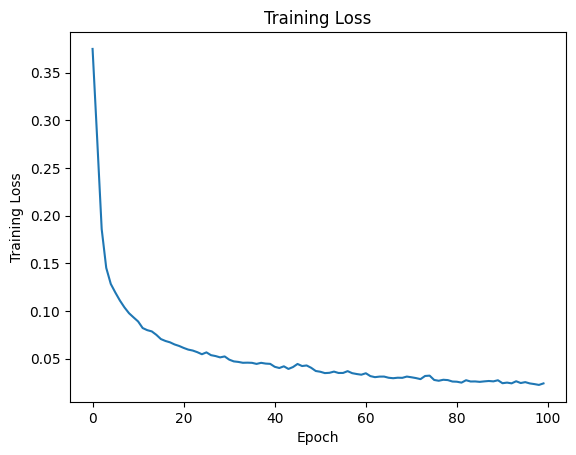

In [13]:
# Assuming you have already defined your models and set up your training loop
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "CPU")

# Initialize models
embed_dim = 128
num_heads = 8
num_layers = 6
num_joints = 14
dropout_rate = 0.1
dof=3
input_dim = num_joints * dof

start_token = torch.zeros(1, num_joints, 3).to(device)  # Assuming start token

# Assuming sequence length
input_length = 30
predict_length = 2
batch_size = 1

X_pos, X_vel, X_acc, Y_pos, Y_vel, Y_acc = generate_sequences(norm_pos, norm_vel, norm_acc, input_length, predict_length)

tgt_mask= create_shifted_mask((input_length-1), num_joints)
tgt_mask = tgt_mask.to(device)

# Convert to PyTorch tensors
X_pos_tensor = torch.tensor(X_pos, dtype=torch.float32)
X_vel_tensor = torch.tensor(X_vel, dtype=torch.float32)
X_acc_tensor = torch.tensor(X_acc, dtype=torch.float32)

Y_pos_tensor = torch.tensor(Y_pos, dtype=torch.float32)
Y_vel_tensor = torch.tensor(Y_vel, dtype=torch.float32)
Y_acc_tensor = torch.tensor(Y_acc, dtype=torch.float32)

# Create the full dataset
full_dataset = TensorDataset(X_pos_tensor, X_vel_tensor, X_acc_tensor, Y_pos_tensor, Y_vel_tensor, Y_acc_tensor)

# Data loader

train_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)

#Defining Models
embedding = SkeletalInputEmbedding(input_dim).to(device)
encoder = TransformerEncoder(embed_dim, num_heads, num_layers, dropout_rate).to(device)
decoder = TransformerDecoder(embed_dim, num_heads, num_layers, num_joints, dropout_rate).to(device)

# Loss function
#criterion = nn.MSELoss()
criterion = MaskedMSELoss()

# Optimizer
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.00001) #0.00001


# Training loop
num_epochs = 100
best_loss = float('inf')
train_losses = []

for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    total_loss = 0.0

    for batch in train_loader:
        # Unpack batch
        X_pos_batch, X_vel_batch, X_acc_batch, Y_pos_batch, Y_vel_batch, Y_acc_batch = batch

        # Memory Data
        X_pos_batch = X_pos_batch.to(device)
        X_vel_batch = X_vel_batch.to(device)
        X_acc_batch = X_acc_batch.to(device)

        inputembeddings = embedding(X_pos_batch)
       
        memory = encoder(inputembeddings, src_key_padding_mask=None)

        # Output Data
        Y_pos_batch = Y_pos_batch.to(device)
        Y_vel_batch = Y_vel_batch.to(device)
        Y_acc_batch = Y_acc_batch.to(device)

        #Target Data
        Y_pos_target=X_pos_batch[:, -1:, :, :]
        Y_vel_target=Y_vel_batch[:,:-1,:,:]
        Y_acc_target=Y_acc_batch[:,:-1,:,:]

        #Expected Data 
        
        Y_pos_expected=Y_pos_batch[:,1:,:,:]

        targetembeddings = embedding(Y_pos_target)

        # Perform forward pass through decoder
        output = decoder(targetembeddings, memory, tgt_key_padding_mask=None, memory_key_padding_mask=None)

        output = output.where(~torch.isnan(output), torch.zeros_like(output))
        Y_pos_expected = Y_pos_expected.where(~torch.isnan(Y_pos_expected), torch.zeros_like(Y_pos_expected))

                
        # print("input embeddings: ", np.shape(inputembeddings))
        # print("memory: ", np.shape(memory))
        # print("target: ", np.shape(targetembeddings))
        # print("output: ", np.shape(output))
        # print("Expected output: ", np.shape(Y_pos_expected))
        # Compute loss
        loss = criterion(output, Y_pos_expected)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate total loss for the epoch
        total_loss += loss.item()

    # Calculate average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # Print or log average loss for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    
    # Save model weights if the current epoch has the best loss
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({
            'epoch': epoch,
            'embedding_state_dict': embedding.state_dict(),
            'encoder_state_dict': encoder.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss
        }, '/home/maleen/research_data/Transformers/models/TF_tokenised/24_06_12_v1_best_model.pth')
        print(f'Saved new best model with validation loss: {avg_loss:.4f}')


# Plot training loss
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss')
plt.show()


In [14]:
# # Load saved model
# checkpoint = torch.load('best_model.pth')
# encoder.load_state_dict(checkpoint['encoder_state_dict'])
# decoder.load_state_dict(checkpoint['decoder_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [15]:
Y_pos_tensor[0][0]

tensor([[-0.8829, -0.6549, -0.3889],
        [-0.8978, -0.6621, -0.5909],
        [-0.3313, -0.6653,  0.0043],
        [-0.0654, -0.6781, -0.3183],
        [-0.0562, -0.6203, -0.0873],
        [-0.7367, -0.6627, -0.9613],
        [-1.3294, -0.3376,  0.3648],
        [-1.1427, -0.3913,  1.6525],
        [-0.5774, -0.6083, -0.4944],
        [-0.8555, -0.5855, -0.2474],
        [-0.8558, -0.6512, -0.4652],
        [-0.8931, -0.6483, -0.6078],
        [-0.5551, -0.7153, -0.1938],
        [-0.8300, -0.6607, -0.8482]])

In [16]:
X_pos_tensor[30][0]

tensor([[-0.8829, -0.6549, -0.3889],
        [-0.8978, -0.6621, -0.5909],
        [-0.3313, -0.6653,  0.0043],
        [-0.0654, -0.6781, -0.3183],
        [-0.0562, -0.6203, -0.0873],
        [-0.7367, -0.6627, -0.9613],
        [-1.3294, -0.3376,  0.3648],
        [-1.1427, -0.3913,  1.6525],
        [-0.5774, -0.6083, -0.4944],
        [-0.8555, -0.5855, -0.2474],
        [-0.8558, -0.6512, -0.4652],
        [-0.8931, -0.6483, -0.6078],
        [-0.5551, -0.7153, -0.1938],
        [-0.8300, -0.6607, -0.8482]])